<a href="https://colab.research.google.com/github/AlexHuggler/AlexHuggler/blob/main/Housing_Active_Inventory_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dallas-Fortworth-Arlington Active Home Listings Machine Learning Forecast 🎯

 ## Installing relevant packages, importing libraries, and defining API key

In [1]:
#pip install fredapi
#pip install prophet


In [2]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as pyo
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from fredapi import Fred
from datetime import date
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import matplotlib.pyplot as plt



In [3]:
# Set up FRED API key and data series ID
fred = Fred(api_key='YOUR KEY')


## Searching FRED for 'Dallas' Related data sets, by popularity. 🖥️

In [4]:
housing_search = fred.search("Dallas", order_by ='popularity')

In [5]:
housing_search

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
WEI,WEI,2023-04-22,2023-04-22,Weekly Economic Index (Lewis-Mertens-Stock),2008-01-05,2023-04-15,"Weekly, Ending Saturday",W,Index,Index,Not Seasonally Adjusted,NSA,2023-04-20 10:36:01-05:00,67,The WEI is an index of real economic activity ...
PCETRIM12M159SFRBDAL,PCETRIM12M159SFRBDAL,2023-04-22,2023-04-22,Trimmed Mean PCE Inflation Rate,1978-01-01,2023-02-01,Monthly,M,Percent Change from Year Ago,% Chg. from Yr. Ago,Seasonally Adjusted,SA,2023-03-31 12:33:01-05:00,61,The Trimmed Mean PCE inflation rate produced b...
DAXRNSA,DAXRNSA,2023-04-22,2023-04-22,S&P/Case-Shiller TX-Dallas Home Price Index,2000-01-01,2023-01-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2023-03-30 10:39:07-05:00,57,"For more information regarding the index, plea..."
MVMTD027MNFRBDAL,MVMTD027MNFRBDAL,2023-04-22,2023-04-22,Market Value of Marketable Treasury Debt,1942-01-01,2023-03-01,Monthly,M,Billions of Dollars,Bil. of $,Not Seasonally Adjusted,NSA,2023-04-12 18:41:01-05:00,52,"For many uses, market value more accurately re..."
ACTLISCOU19100,ACTLISCOU19100,2023-04-22,2023-04-22,Housing Inventory: Active Listing Count in Dal...,2016-07-01,2023-03-01,Monthly,M,Level,Level,Not Seasonally Adjusted,NSA,2023-03-30 16:45:03-05:00,51,The count of active single-family and condo/to...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AUSINFOA674AFRBDAL,AUSINFOA674AFRBDAL,2023-04-22,2023-04-22,Information Payroll Employment for Austin-Roun...,1991-01-01,2022-01-01,Annual,A,December to December Percent Change,Dec to Dec % Chg.,Not Seasonally Adjusted,NSA,2023-03-10 14:41:36-06:00,1,The Dallas Fed has improved the quality of the...
LAUCN481390000000005,LAUCN481390000000005,2023-04-22,2023-04-22,"Employed Persons in Ellis County, TX",1990-01-01,2023-02-01,Monthly,M,Persons,Persons,Not Seasonally Adjusted,NSA,2023-04-05 10:27:10-05:00,1,These data come from the Current Population Su...
SMU48191003100000001,SMU48191003100000001,2023-04-22,2023-04-22,All Employees: Manufacturing: Durable Goods in...,1990-01-01,2023-03-01,Monthly,M,Thousands of Persons,Thous. of Persons,Not Seasonally Adjusted,NSA,2023-04-22 02:50:30-05:00,1,None


In [6]:
housing_search.shape

(1000, 15)

In [7]:
series_id = 'ACTLISCOU19100'



In [8]:
housing_search = fred.search(series_id)

## Pulling in Raw Data and Plotting 

In [9]:
# Retrieve data from FRED API
data = fred.get_series(series_id)

In [10]:
# Set start and end dates for data, pulling today's date for constant pull
today = date.today()

start_date = '2010-01-01'
end_date = today.strftime('%Y-%m-%d')

# Retrieve data from FRED API
data = fred.get_series(series_id, start_date=start_date, end_date=end_date)


df = pd.DataFrame(data)



In [11]:
data

2016-07-01    15741.0
2016-08-01    16496.0
2016-09-01    16133.0
2016-10-01    16072.0
2016-11-01    15513.0
               ...   
2022-11-01    17885.0
2022-12-01    16320.0
2023-01-01    14673.0
2023-02-01    12786.0
2023-03-01    12398.0
Length: 81, dtype: float64

In [12]:
print(type(data))

<class 'pandas.core.series.Series'>


<Axes: title={'center': ' Housing Inventory: Active Listing Count in Dallas-Fort Worth-Arlington, TX '}>

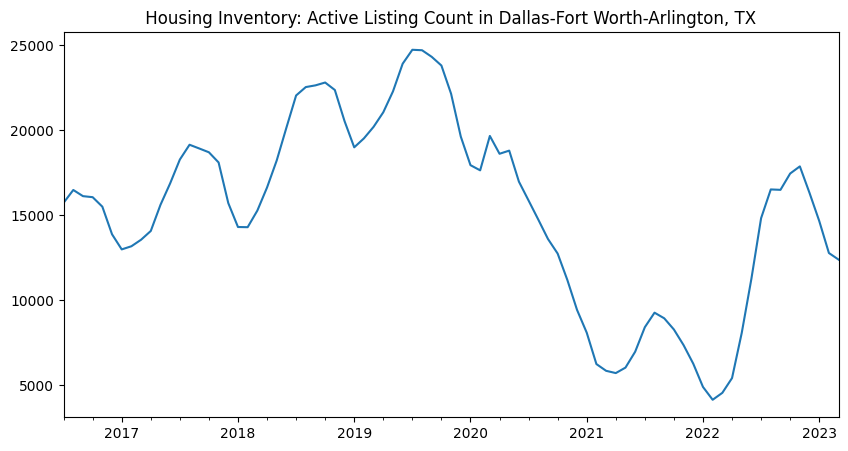

In [13]:
data.plot(figsize=(10,5), title= ' Housing Inventory: Active Listing Count in Dallas-Fort Worth-Arlington, TX ')

In [14]:
# Load data into a df
df =  pd.DataFrame({'date': data.index, 'value': data.values})

# Rename columns
df.columns = ['ds', 'y']


In [15]:
df

,ds,y
0,2016-07-01,15741.0
1,2016-08-01,16496.0
2,2016-09-01,16133.0
3,2016-10-01,16072.0
4,2016-11-01,15513.0
...,...,...
76,2022-11-01,17885.0
77,2022-12-01,16320.0
78,2023-01-01,14673.0
79,2023-02-01,12786.0


## Seasonal Decomposition to Extract Underlying Components of the Time Series Data

  Seasonal decomposition is a technique used to extract the seasonal, trend, and residual components of a time series. It can be used to better understand the underlying structure of the data, remove the seasonal and trend components to analyze the random fluctuations, and build more accurate forecasting models by identifying the seasonal and trend patterns in the data.

In the below data, we can see that there's a common seasonality seen in the housing market for the DFW area, where housing inventory dips in the winter, then increases in the summer months. This follows the adage that folks "buy in the winter and sell in the summer".

In [16]:
# Load data into a seprate df for seasonal decomposition
df1 =  pd.DataFrame({'date': data.index, 'value': data.values})

# Set the 'date' column as the index
df1.set_index('date', inplace=True)

# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(df1['value'], model='additive')

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

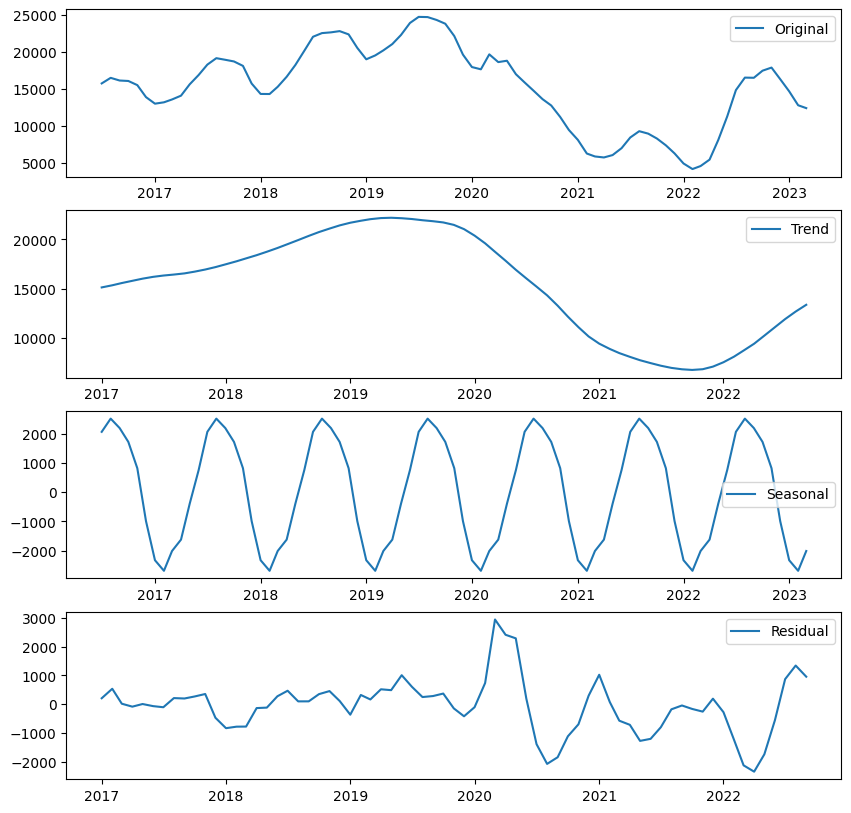

In [17]:

# Plot the components
fig, axs = plt.subplots(4, 1, figsize=(10,10))
axs[0].plot(df1.index, df1['value'], label='Original')
axs[0].legend()
axs[1].plot(trend.index, trend, label='Trend')
axs[1].legend()
axs[2].plot(seasonal.index, seasonal, label='Seasonal')
axs[2].legend()
axs[3].plot(residual.index, residual, label='Residual')
axs[3].legend()

plt.show()

## Applying First Iteration of Prophet Forecasting model

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpotlan6mi/wd1h19jm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpotlan6mi/v4p5rn88.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94561', 'data', 'file=/tmp/tmpotlan6mi/wd1h19jm.json', 'init=/tmp/tmpotlan6mi/v4p5rn88.json', 'output', 'file=/tmp/tmpotlan6mi/prophet_modelvzkdah5t/prophet_model-20230423010625.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:06:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:06:26 - cmdstanpy - INFO - Chain [1] do

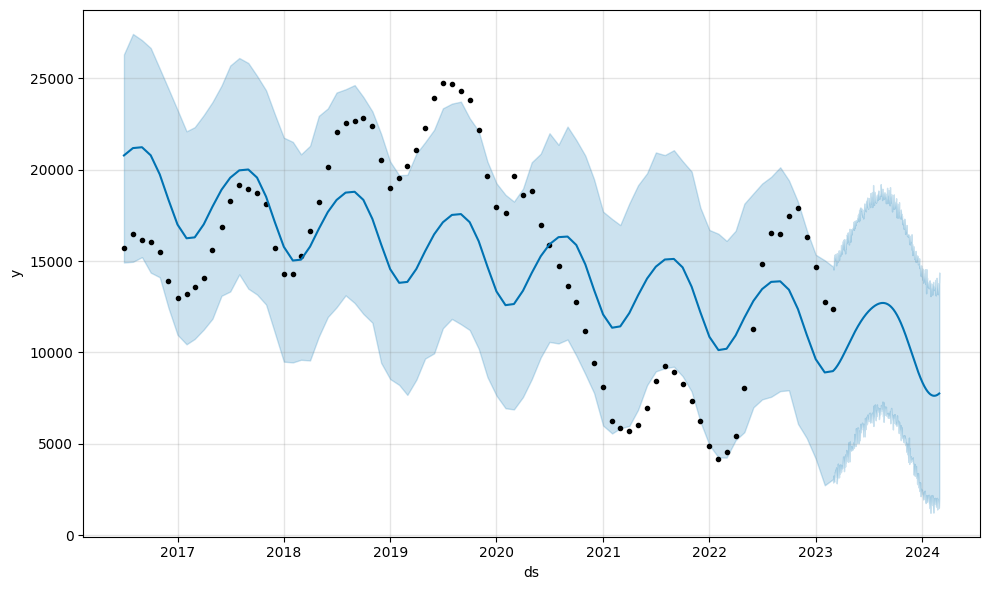

In [18]:
# Create the model
m = Prophet(seasonality_mode='additive', growth ='linear')
m.add_seasonality(name='yearly', period=365, fourier_order=2)

# Fit the model to the data
m.fit(df)

# Make future predictions
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

# Plot the forecast
fig = m.plot(forecast)

### Initial issues with Prophet ⚠️

From the below graph, we can see that from the code I've inputted, the Prophet model is accounting for all the time series data and is predicting a long term downward trend, based on the overall trend seen between 2017-2022. To accomodate for this, I'll try reviewing the last 30 months of data, in order to capture more of what the "current" trend is based off of the last 30 months.

In [19]:
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], mode='lines', name='Observed'), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Predicted'), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', line=dict(color='grey'), name='Lower Bound'), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', line=dict(color='grey'), fill='tonexty', name='Upper Bound'), row=1, col=1)
fig.update_layout(title=' Housing Inventory: Active Listing Count in Dallas-Fort Worth-Arlington, TX - Time Series Forecast', xaxis_title='Date', yaxis_title='Value', template='plotly_white')

# Show the plot
fig.show()

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpotlan6mi/tfmlxunv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpotlan6mi/rtlo35s4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35071', 'data', 'file=/tmp/tmpotlan6mi/tfmlxunv.json', 'init=/tmp/tmpotlan6mi/rtlo35s4.json', 'output', 'file=/tmp/tmpotlan6mi/prophet_model_cbbvjck/prophet_model-20230423010628.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:06:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmds

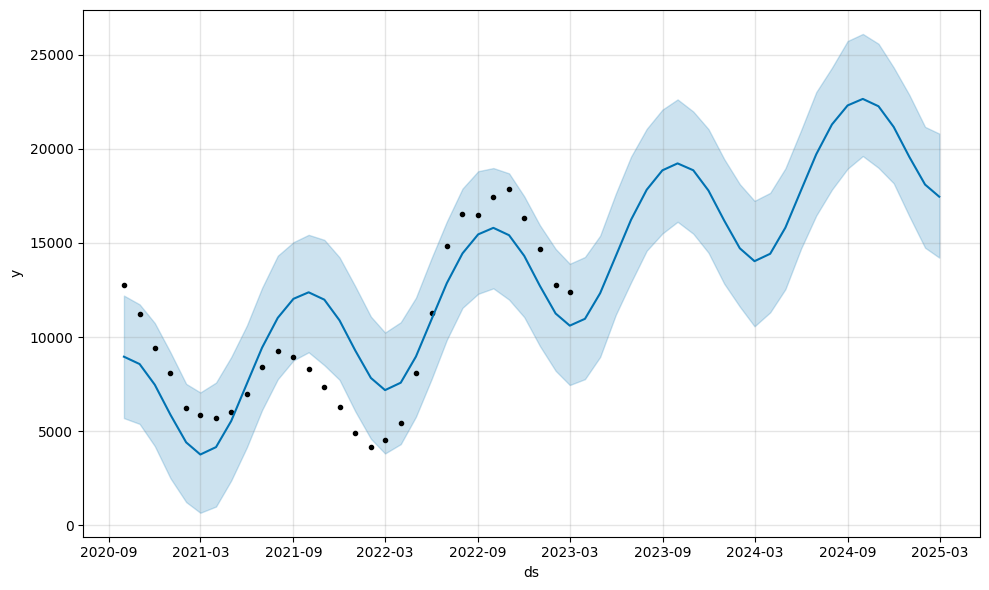

In [20]:
# Subset the original dataframe to select only the last 30 months of data
last_24_months = df.tail(30)

# Create the model
m = Prophet(seasonality_mode='additive', growth='linear')
m.add_seasonality(name='yearly', period=365, fourier_order=2)

# Fit the model to the last 30 months of data
m.fit(last_24_months)

# Make future predictions for the next 30 months
future = m.make_future_dataframe(periods=24, freq='M')
forecast = m.predict(future)

# Plot the forecast
fig = m.plot(forecast)

### More Sensible Prophet forecast, based on nearer data 📈

As can be seen below, accounting for the last 30 months of data in the model has provided a more conservative and agreeable forecast, that over the next 2-3 years, we can expect housing inventory to increase towards more pre-pandemic levels. However, this will ultimately be based on a number of other economic and societal factors outside the scope of the model created today. 

In [21]:
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], mode='lines', name='Observed'), row=1, col=1)

# Filter forecast data to show only values after last actual observation
last_observed_date = df['ds'].max()
forecast_filtered = forecast[forecast['ds'] > last_observed_date]

fig.add_trace(go.Scatter(x=forecast_filtered['ds'], y=forecast_filtered['yhat'], mode='lines', name='Predicted'), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast_filtered['ds'], y=forecast_filtered['yhat_lower'], mode='lines', line=dict(color='grey'), name='Lower Bound'), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast_filtered['ds'], y=forecast_filtered['yhat_upper'], mode='lines', line=dict(color='grey'), fill='tonexty', name='Upper Bound'), row=1, col=1)

fig.update_layout(title='Housing Inventory: Active Listing Count in Dallas-Fort Worth-Arlington, TX - Time Series Forecast', xaxis_title='Date', yaxis_title='Value', template='plotly_white')

# Show the plot
fig.show()

## Comparison to ARIMA Model

Seen in the output below, taking the same 30 month strategy and putting the data into an ARIMA forecast, shows that the ARIMA model may be factoring in more of the deep decline seen between Oct 2020 and Apr 2021, than the Prophet model.


In [22]:
# Fit ARIMA model with yearly seasonality to data
model = sm.tsa.ARIMA(df1['value'], order=(1, 0, 0), seasonal_order=(0, 1, 1, 12))
results = model.fit()

# Generate forecast for next 36 months
forecast = results.forecast(steps=36)

# Create Plotly figure object
fig = go.Figure()

# Add actual data trace
fig.add_trace(go.Scatter(x=df1.index, y=df1['value'], name='Actual'))

# Add last 30 months of actual data trace
last_30_months = df1.tail(30)
fig.add_trace(go.Scatter(x=last_30_months.index, y=last_30_months['value'], name='Actual (last 30 months)'))

# Add forecast trace
forecast_dates = pd.date_range(df1.index[-1], periods=36, freq='M')
fig.add_trace(go.Scatter(x=forecast_dates, y=forecast, name='Forecast'))

# Add axis labels and title
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Value',
    title='ARIMA Forecast'
)

# Display plot
fig.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

